In [1]:
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import matplotlib.pyplot as plt
import pylab 

In [219]:
pd.set_option('display.max_columns', None)

def linear_regression(X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    b = np.linalg.inv(X.T@X)@X.T@y
    return b

def rmse(slopes, X_test, y_test):
    X_test = pd.get_dummies(X_test, drop_first = True)._get_numeric_data().values
    intercept_col = np.ones(X_test.shape[0]).reshape(X_test.shape[0],1)
    X_test = np.hstack((intercept_col, X_test))
    
    y_val_pred = X_test @ b
    y_val = y_test.values
    return np.sqrt(((y_val - y_val_pred) ** 2).mean())
    
def train_test_split(frac, X, response = 'Volume Sold (Gallons)'):
    X_train = X.sample(frac = frac)
    X_test = X.drop(X_train.index, axis = 0)
    

    y_train = X_train[response]
    X_train = X_train.drop(['County','Area Name',response], axis = 1)
    
   
    y_test = X_test[response]
    X_test = X_test.drop(['County','Area Name',response], axis = 1)
    
    
    return X_train,X_test, y_train, y_test

def r2(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    
    y_val_pred = X @ b
    ss_res = ((y - y_val_pred) ** 2).sum()
    return 1 - (ss_res/ss_tot)

def qqplot(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    y_val_pred = X @ b

    stats.probplot(y - y_val_pred, dist="norm", plot=pylab)
    pylab.show()
def resid_vs_fit(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    y_val_pred = X @ b
    resid = y - y_val_pred
    plt.scatter(y_val_pred, resid)
    plt.show()
    
def aic(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    y_val_pred = X @ b
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    ss_res = ((y - y_val_pred) ** 2).sum()
    sigmasq = ss_tot / X.shape[0]
    p = X.shape[1]
    
    return (ss_res + 2 *(p * sigmasq)) / ss_tot

def bic(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    y_val_pred = X @ b
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    ss_res = ((y - y_val_pred) ** 2).sum()
    sigmasq = ss_tot / X.shape[0]
    p = X.shape[1]
    n = X.shape[0]
    
    return (ss_res + (np.log(n) * p * sigmasq)) / ss_tot

def adj_r2(b, X, y):
    X = pd.get_dummies(X, drop_first = True)._get_numeric_data().values
    y = y.values
    intercept_col = np.ones(X.shape[0]).reshape(X.shape[0],1)
    X = np.hstack((intercept_col, X))
    
    ss_tot = ((y - y.mean()) ** 2).sum()
    
    y_val_pred = X @ b
    ss_res = ((y - y_val_pred) ** 2).sum()
    
    r2 = 1 - (ss_res/ss_tot)
    return 1 - (((1 - r2) * (X.shape[0] - 1)) / (X.shape[0] - X.shape[1] - 1))

def cross_validation(X, y, k):
    rmses = []
    index_array = list(X.index)
    np.random.shuffle(index_array)
    index_folds = np.array_split(index_array, 5)
    for i in range(k):
        training_index = np.concatenate(index_folds[:i] + index_folds[(i+1):])
        test_index = index_folds[i]
        X_train = X.loc[training_index]
        y_train = y.loc[training_index]
        X_test = X.loc[test_index]
        y_test = y.loc[test_index]
        b = linear_regression(X_train, y_train)
        rmses.append(rmse(b, X_test, y_test))
    return np.mean(rmses)

In [3]:
df = pd.read_csv("../data/iowaliquor.csv")
df_sample = pd.read_csv("../data/iowa-sample.csv")
df_pop = pd.read_csv("../data/County_Population_in_Iowa_by_Year.csv")


/Users/anishyakkala/Library/Python/3.6/lib/python/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (6,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [75]:
df_raw_employment = pd.read_csv("../data/Iowa_Quarterly_Census_of_Employment_and_Wage_data__Statewide_and_County_.csv")
df_raw_employment.fillna(0)
df_raw_employment["Area Name"] = df_raw_employment["Area Name"].str.lower()

In [78]:
df_employement = pd.pivot_table(df_raw_employment,
               index = ["Year", "Quarter", "Area Name"],
               values = ["Average Emp", "Wages"],
               aggfunc = np.sum
              ).reset_index()

In [80]:
df_employement = df_employement.merge(pd.pivot_table(df_raw_employment,
                                       index = ["Year", "Quarter", "Area Name"],
                                       values = ["Average Wage"],
                                       aggfunc = np.mean
                                      ).reset_index(),
                                        'inner')

In [81]:
df_employement["Year"] = df_employement["Year"].astype('str')
df_employement["Quarter"] = df_employement["Quarter"].astype('str')

In [159]:
df.head()

,Invoice/Item Number,Date,Store Number,Store Name,Address,City,Zip Code,Store Location,County Number,County,Category,Category Name,Vendor Number,Vendor Name,Item Number,Item Description,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Year,Quarter
0,S08096000008,10/04/2012,4641,Kum & Go #573 / SE 14th DM,5830 SE 14th ST,DES MOINES,50315,NaN,77.0,polk,1022100.0,TEQUILA,395.0,Proximo,89191,Jose Cuervo Especial Reposado Tequila Mini,12,500,11.50,17.25,1,17.25,0.50,0.13,2012,4
1,S23102300041,12/20/2014,4346,Roy's Foodland,105 PEARL ST,SHELLSBURG,52332,POINT (-91.869285 42.094155),6.0,benton,1012100.0,CANADIAN WHISKIES,115.0,"Constellation Wine Company, Inc.",11774,Black Velvet,24,375,3.07,4.61,6,27.66,2.25,0.59,2014,4
2,S14410500035,09/09/2013,3628,Wal-Mart 1528 / Cedar Rapids,2645 BLAIRS FERRY RD NE,CEDAR RAPIDS,52402,POINT (-91.680734 42.034748),57.0,linn,1062300.0,FLAVORED RUM,260.0,Diageo Americas,43410,Captain Morgan Parrot Bay Coconut,12,750,7.49,11.23,12,134.76,9.00,2.38,2013,3
3,S09427600021,12/12/2012,4708,No Frills Supermarkets #803 / Glenwo,423 SHARP ST,GLENWOOD,51534,POINT (-95.742987 41.04635),65.0,mills,1011100.0,BLENDED WHISKIES,65.0,Jim Beam Brands,24458,Kessler Blend Whiskey,6,1750,11.01,16.52,30,495.60,52.50,13.87,2012,4
4,S28446900114,10/14/2015,2594,Hy-Vee Food Store / Sioux City,4500 SERGEANT ROAD,SIOUX CITY,51106,POINT (-96.346969 42.447396),97.0,woodbury,1012100.0,CANADIAN WHISKIES,115.0,"Constellation Wine Company, Inc.",10550,Black Velvet Toasted Caramel,12,750,6.75,10.13,12,121.56,9.00,2.38,2015,4


In [7]:
df["County"] = df["County"].str.lower()

In [8]:
df["Year"] = pd.DatetimeIndex(df['Date']).year
df["Quarter"] = pd.DatetimeIndex(df['Date']).quarter

In [9]:
df["Year"] = df["Year"].astype('str')
df["Quarter"] = df["Quarter"].astype('str')
df["Pack"] = df["Pack"].astype('str')

In [82]:
GROUP_VARIABLES = ['County','Year','Quarter']
NUMERIC_VARIABLES = ['Bottle Volume (ml)','State Bottle Cost', 'State Bottle Retail',
                     'Bottles Sold','Sale (Dollars)', 'Volume Sold (Liters)', 'Volume Sold (Gallons)']

df_agg =  pd.pivot_table(df, 
                        index = GROUP_VARIABLES,
                        values = NUMERIC_VARIABLES,
                        aggfunc = np.sum).reset_index().merge(df_employement, 'inner', left_on = ['Year','County', 'Quarter'], right_on = ['Year','Area Name', 'Quarter']).dropna()

In [11]:
df_pop["Year"] = df_pop["Year"].str[-4:]

In [12]:
df_pop["County"] = df_pop["County"].str.replace(" County","").str.lower()

In [83]:
df_agg = df_agg.merge(df_pop[["Year","County","Population"]],
             'inner',
             left_on = ['Year', 'County'],
             right_on = ['Year', 'County'])

In [347]:
NUMERIC_RESPONSE = ['Sale (Dollars)', 'Volume Sold (Gallons)', 'Volume Sold (Liters)']

for column in NUMERIC_RESPONSE:
    df_agg[column + " Per Capita"] = df_agg[column] / df_agg["Population"]
    df_agg[column + " Per Capita - Log"] = np.log(df_agg[column + " Per Capita"])
    df_agg[column + " Per Capita - Sqrt"] = df_agg[column + " Per Capita"] ** 0.5

In [348]:
NUMERIC_COLUMNS = ['Bottle Volume (ml)', 'Bottles Sold', 'Average Emp', 'Wages',
                   'Average Wage', 'Population']

for column in NUMERIC_COLUMNS:
    df_agg[column + " Per Capita"] = df_agg[column] / df_agg["Population"]
    
CATEGORICAL_COLUMNS = ['Year', 'Quarter']

In [349]:
df_results = pd.DataFrame({"Independent Variables":[],
                           "Dependent Variable":[],
                           "RMSE":[],
                           "R2":[],
                           "Adj R2":[]
                          })

In [390]:
DEPENDENT_VARIABLES = ['Year','Quarter','Bottle Volume (ml)','State Bottle Cost', 'State Bottle Retail',
                     'Bottles Sold','Wages Per Capita', 'Average Emp Per Capita']

In [391]:
from itertools import chain, combinations

def powerset(iterable):
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [392]:
DEPENDENT_VARIABLES = list(powerset(DEPENDENT_VARIABLES))
DEPENDENT_VARIABLES = [list(iterable) for iterable in DEPENDENT_VARIABLES if iterable != ()]

In [393]:
NUMERIC_RESPONSE = ['Sale (Dollars)', 'Volume Sold (Gallons)', 'Volume Sold (Liters)']
df_results = pd.DataFrame({"Independent Variables":[],
                           "Dependent Variable":[],
                           "RMSE":[],
                           "R2":[],
                           "Adj R2":[]
                          })
for DEP_VAR in NUMERIC_RESPONSE:
    DEP_VAR_ = DEP_VAR
    for IND_VARS in DEPENDENT_VARIABLES:
        DEP_VAR = DEP_VAR_ + " Per Capita"
        X_train, X_test, y_train, y_test = train_test_split(.5, df_agg, DEP_VAR)
        b = linear_regression(X_train[IND_VARS], y_train)
        new_row = {"Independent Variables": IND_VARS,
                   "Dependent Variable" : DEP_VAR,
                   "RMSE": rmse(b, X_test[IND_VARS], y_test),
                   "R2" : r2(b, X_test[IND_VARS], y_test),
                   "Adj R2" : adj_r2(b, X_test[IND_VARS], y_test),
                   "Cross Validation RMSE" : cross_validation(df_agg[IND_VARS], df_agg[DEP_VAR], 5)
                  }
        df_results = df_results.append(new_row, ignore_index = True)
        
        DEP_VAR = DEP_VAR_ + " Per Capita - Sqrt"
        X_train,X_test, y_train, y_test = train_test_split(.5, df_agg, DEP_VAR)
        b = linear_regression(X_train[IND_VARS], y_train)
        new_row = {"Independent Variables": IND_VARS,
           "Dependent Variable" : DEP_VAR,
           "RMSE": rmse(b, X_test[IND_VARS], y_test),
           "R2" : r2(b, X_test[IND_VARS], y_test),
           "Adj R2" : adj_r2(b, X_test[IND_VARS], y_test),
           "Cross Validation RMSE" : cross_validation(df_agg[IND_VARS], df_agg[DEP_VAR], 5)
          }
        df_results = df_results.append(new_row, ignore_index = True)
        
        DEP_VAR = DEP_VAR_ + " Per Capita - Log"
        X_train,X_test, y_train, y_test = train_test_split(.5, df_agg, DEP_VAR)
        b = linear_regression(X_train[IND_VARS], y_train)
        new_row = {"Independent Variables": IND_VARS,
           "Dependent Variable" : DEP_VAR,
           "RMSE": rmse(b, X_test[IND_VARS], y_test),
           "R2" : r2(b, X_test[IND_VARS], y_test),
           "Adj R2" : adj_r2(b, X_test[IND_VARS], y_test),
           "Cross Validation RMSE" : cross_validation(df_agg[IND_VARS], df_agg[DEP_VAR], 5)
          }
        
        df_results = df_results.append(new_row, ignore_index = True)

In [397]:
pd.set_option('display.max_colwidth', -1)
df_results.sort_values('Adj R2', ascending = False).head(10)[["Independent Variables","Dependent Variable", "Adj R2", "RMSE"]]

/Users/anishyakkala/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Independent Variables,Dependent Variable,Adj R2,RMSE
697,"[Year, Quarter, State Bottle Retail, Bottles Sold, Wages Per Capita, Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.636633,0.648174
544,"[Year, Quarter, Bottles Sold, Wages Per Capita, Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.630237,0.632875
727,"[Quarter, Bottle Volume (ml), State Bottle Cost, Bottles Sold, Wages Per Capita, Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.625691,0.651470
763,"[Year, Quarter, Bottle Volume (ml), State Bottle Cost, State Bottle Retail, Bottles Sold, Wages Per Capita, Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.624417,0.661374
694,"[Year, Quarter, State Bottle Cost, Bottles Sold, Wages Per Capita, Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.623932,0.669838
289,"[Year, Quarter, Bottle Volume (ml), Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.623510,0.668171
682,"[Year, Quarter, Bottle Volume (ml), Bottles Sold, Wages Per Capita, Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.623413,0.670887
670,"[Year, Quarter, Bottle Volume (ml), State Bottle Cost, Wages Per Capita, Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.623268,0.656182
745,"[Year, Quarter, Bottle Volume (ml), State Bottle Cost, State Bottle Retail, Wages Per Capita, Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.621726,0.674952
751,"[Year, Quarter, Bottle Volume (ml), State Bottle Retail, Bottles Sold, Wages Per Capita, Average Emp Per Capita]",Sale (Dollars) Per Capita - Sqrt,0.621504,0.650775


In [387]:
pd.set_option('expand_frame_repr', False)

In [382]:
df_results.to_csv("model_results.csv", index = False)

In [404]:
IND_VARS = ["Year", "Quarter", "Average Emp Per Capita", "Wages Per Capita"]
DEP_VAR = 'Sale (Dollars) Per Capita - Sqrt' 
X_train, X_test, y_train, y_test = train_test_split(.5, df_agg, DEP_VAR)
b = linear_regression(X_train[IND_VARS], y_train)

Independent Variables:  ['Year', 'Quarter', 'Average Emp Per Capita', 'Wages Per Capita']
Dependent Variable:  Sale (Dollars) Per Capita - Sqrt
RMSE :  0.6979994909936708
R2 :  0.5812257797028798
Adj R2 :  0.5775170781209127
AIC : 0.436318079946243
BIC : 0.4821172474741597
Cross Validation RMSE : 0.6905612511502522


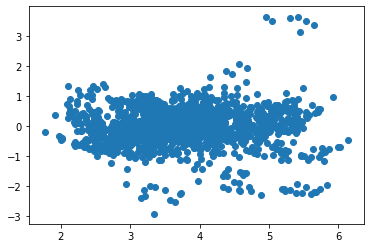

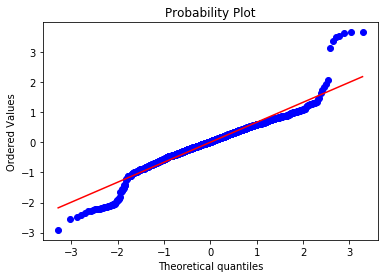

(None, None)

In [405]:
print("Independent Variables: ", IND_VARS)
print("Dependent Variable: ", DEP_VAR)
print("RMSE : ", rmse(b, X_test[IND_VARS], y_test))
print("R2 : ", r2(b, X_test[IND_VARS], y_test))
print("Adj R2 : ", adj_r2(b, X_test[IND_VARS], y_test))
print("AIC :", aic(b, X_test[IND_VARS], y_test))
print("BIC :", bic(b, X_test[IND_VARS], y_test))
print("Cross Validation RMSE :", cross_validation(df_agg[IND_VARS], df_agg[DEP_VAR], 5))

resid_vs_fit(b, X_train[IND_VARS], y_train), qqplot(b, X_train[IND_VARS], y_train)